In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.2


In [2]:
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

In [3]:
# fmt: off
data = pd.DataFrame(dict(
    year = np.arange(1900., 1921., 1),
    lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])))
data.head()
# fmt: on

year  lynx  hare
0  1900.0   4.0  30.0
1  1901.0   6.1  47.2
2  1902.0   9.8  70.2
3  1903.0  35.2  77.4
4  1904.0  59.4  36.3

In [4]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Hudson's Bay Company Data"):
    ax.plot(data.year, data.lynx, color="b", lw=lw, marker="o", markersize=12, label="Lynx (Data)")
    ax.plot(data.year, data.hare, color="g", lw=lw, marker="+", markersize=14, label="Hare (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([1900, 1920])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pelts (Thousands)", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)
    return ax

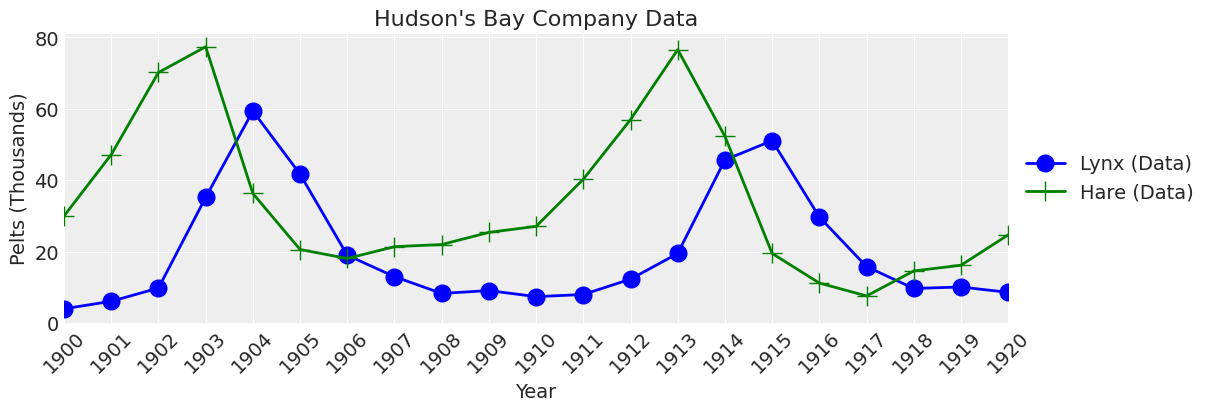

In [5]:
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax);

In [6]:
# define the right hand side of the ODE equations in the Scipy odeint signature
from numba import njit


@njit
def rhs(X, t, theta):
    # unpack parameters
    x, y = X
    alpha, beta, gamma, delta, xt0, yt0 = theta
    # equations
    dx_dt = alpha * x - beta * x * y
    dy_dt = -gamma * y + delta * x * y
    return [dx_dt, dy_dt]

In [7]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=np.arange(1900, 1921, 0.01),
    alpha=1,
    lw=3,
    title="Hudson's Bay Company Data and\nExample Model Run",
):
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="g", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

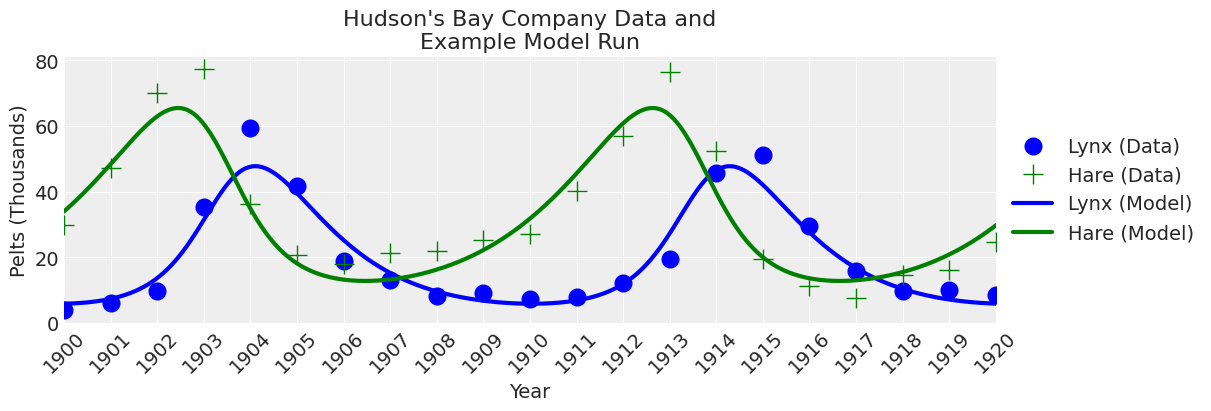

In [8]:
# note theta = alpha, beta, gamma, delta, xt0, yt0
theta = np.array([0.52, 0.026, 0.84, 0.026, 34.0, 5.9])
time = np.arange(1900, 1921, 0.01)

# call Scipy's odeint function
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))

# plot
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y);

In [9]:
# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    return (
        data[["hare", "lynx"]] - odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))
    ).values.flatten()

In [10]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=theta)

# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["alpha", "beta", "gamma", "delta", "h0", "l0"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(2)

Parameter  Least Squares Solution
0     alpha                    0.48
1      beta                    0.02
2     gamma                    0.93
3     delta                    0.03
4        h0                   34.91
5        l0                    3.86

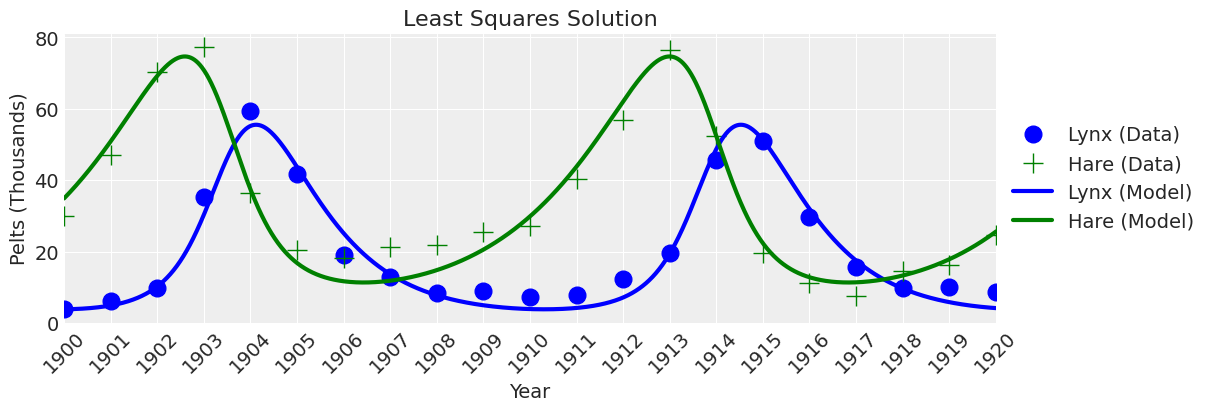

In [11]:
time = np.arange(1900, 1921, 0.01)
theta = results.x
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y, title="Least Squares Solution");

In [12]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))

In [13]:
theta = results.x  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([alpha, beta, gamma, delta, xt0, yt0])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

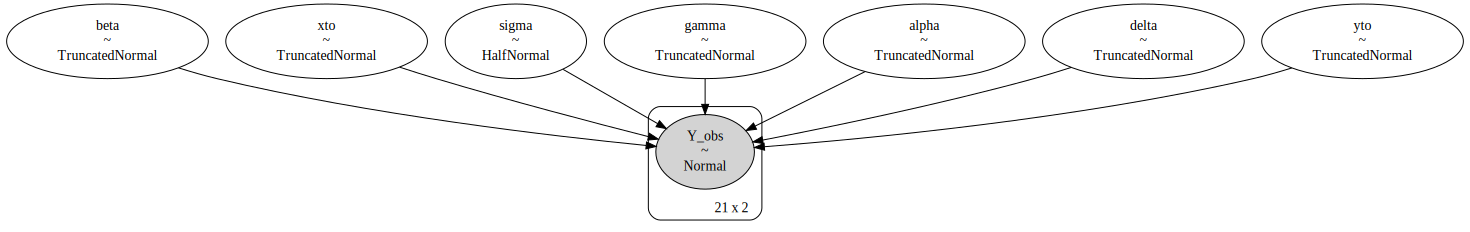

In [14]:
pm.model_to_graphviz(model=model)

In [15]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["alpha", "beta", "gamma", "delta", "xto", "yto"]
    row = trace_df.iloc[row_idx, :][cols].values

    # alpha, beta, gamma, delta, Xt0, Yt0
    time = np.arange(1900, 1921, 0.01)
    theta = row
    x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [16]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hudson's Bay Company Data and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [18]:
vars_list = list(model.values_to_rvs.keys())[:-1]
vars_list

[alpha_interval__,
 beta_interval__,
 gamma_interval__,
 delta_interval__,
 xto_interval__,
 yto_interval__,
 sigma_log__]

In [19]:
# Specify the sampler
sampler = "Slice Sampler"
tune = draws = 2000

# Inference!
with model:
    trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws)
trace = trace_slice
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [gamma]
>Slice: [delta]
>Slice: [xto]
>Slice: [yto]
>Slice: [sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 90 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.481  0.025   0.437    0.528      0.002    0.002     111.0     291.0   
beta    0.025  0.001   0.022    0.027      0.000    0.000     218.0     540.0   
gamma   0.930  0.053   0.833    1.028      0.005    0.004     108.0     303.0   
delta   0.028  0.002   0.025    0.031      0.000    0.000     112.0     324.0   
xto    34.926  0.822  33.337   36.406      0.025    0.017    1102.0    2503.0   
yto     3.872  0.466   3.016    4.759      0.042    0.030     123.0     636.0   
sigma   4.116  0.486   3.243    5.039      0.006    0.005    6031.0    5894.0   

       r_hat  
alpha   1.04  
beta    1.01  
gamma   1.04  
delta   1.04  
xto     1.00  
yto     1.03  
sigma   1.00

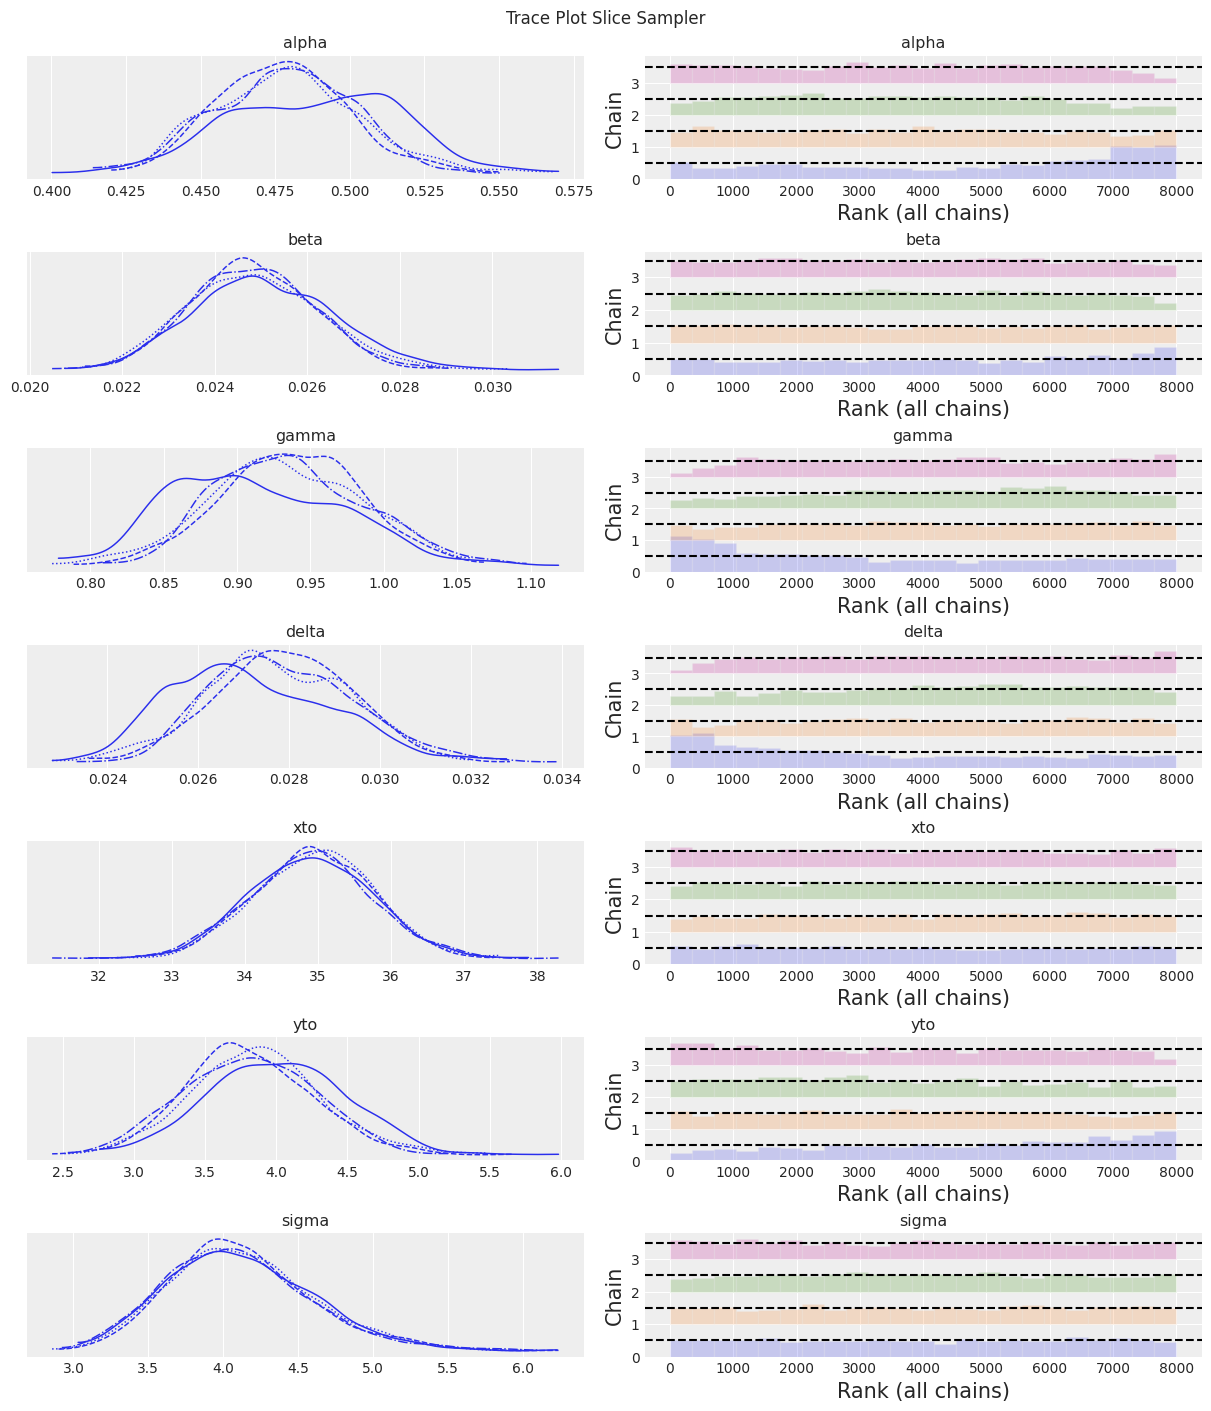

In [20]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

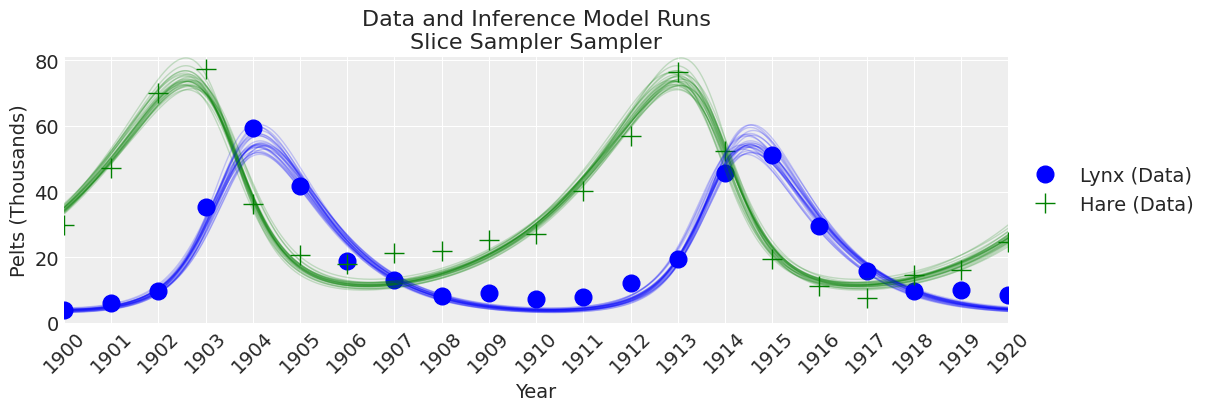

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [22]:
sampler = "DEMetropolisZ"
tune = draws = 5000
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws)
trace = trace_DEMZ
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [alpha, beta, gamma, delta, xto, yto, sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 13 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.483  0.024   0.438    0.529      0.001    0.001     749.0    1302.0   
beta    0.025  0.001   0.022    0.027      0.000    0.000     947.0    1465.0   
gamma   0.924  0.052   0.828    1.023      0.002    0.001     764.0    1481.0   
delta   0.028  0.002   0.025    0.031      0.000    0.000     822.0    1189.0   
xto    34.913  0.821  33.388   36.470      0.028    0.020     844.0    1491.0   
yto     3.939  0.488   3.021    4.857      0.017    0.012     859.0    1378.0   
sigma   4.167  0.508   3.315    5.122      0.020    0.014     686.0    1119.0   

       r_hat  
alpha   1.01  
beta    1.00  
gamma   1.01  
delta   1.01  
xto     1.00  
yto     1.01  
sigma   1.01

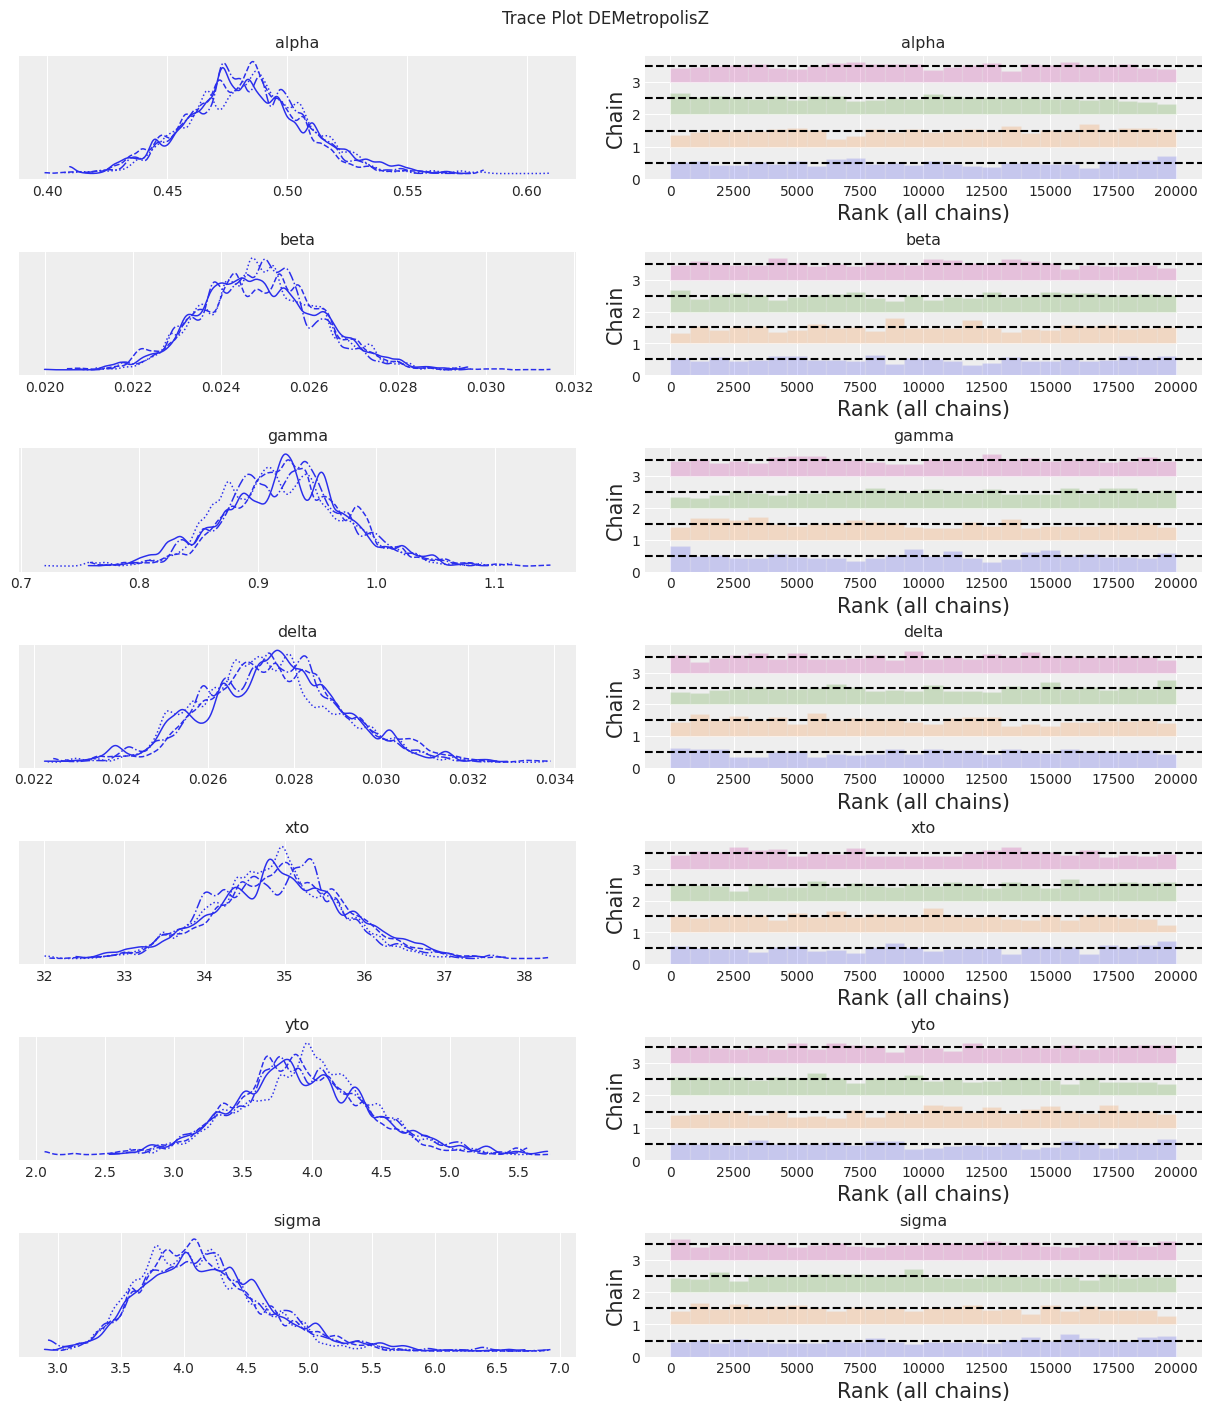

In [23]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

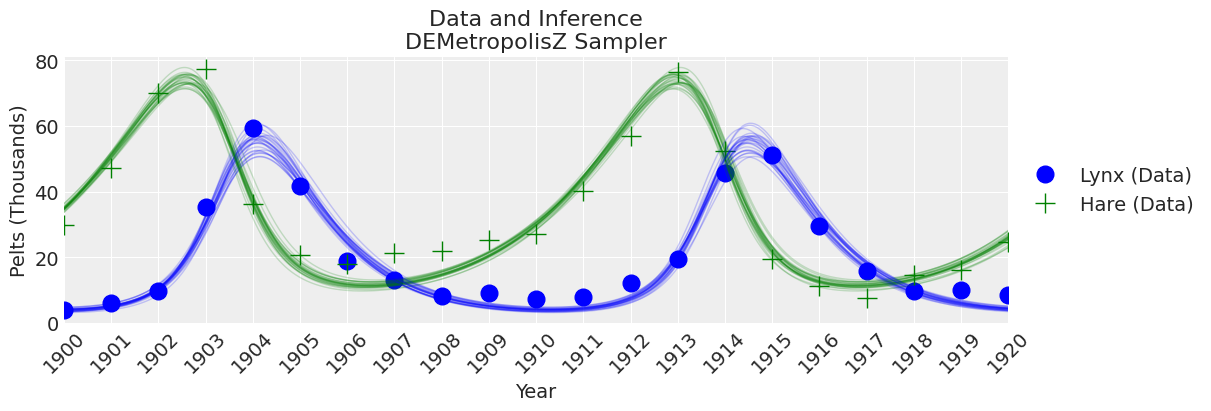

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference\n{sampler} Sampler")

In [25]:
sampler = "DEMetropolis"
chains = 8
draws = 6000
with model:
    trace_DEM = pm.sample(step=[pm.DEMetropolis(vars_list)], draws=draws, chains=chains)
trace = trace_DEM
az.summary(trace)

Population sampling (8 chains)
DEMetropolis: [alpha, beta, gamma, delta, xto, yto, sigma]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 6_000 draw iterations (8_000 + 48_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.483  0.021   0.446    0.523      0.001    0.000    1358.0    3112.0   
beta    0.025  0.001   0.023    0.027      0.000    0.000    1476.0    2864.0   
gamma   0.925  0.044   0.841    1.005      0.001    0.001    1513.0    3066.0   
delta   0.028  0.001   0.025    0.030      0.000    0.000    1585.0    2353.0   
xto    34.890  0.743  33.513   36.293      0.018    0.013    1730.0    3409.0   
yto     3.909  0.381   3.181    4.638      0.009    0.006    1979.0    2565.0   
sigma   4.036  0.403   3.261    4.755      0.010    0.007    1511.0    2728.0   

       r_hat  
alpha   1.01  
beta    1.01  
gamma   1.01  
delta   1.01  
xto     1.00  
yto     1.00  
sigma   1.01

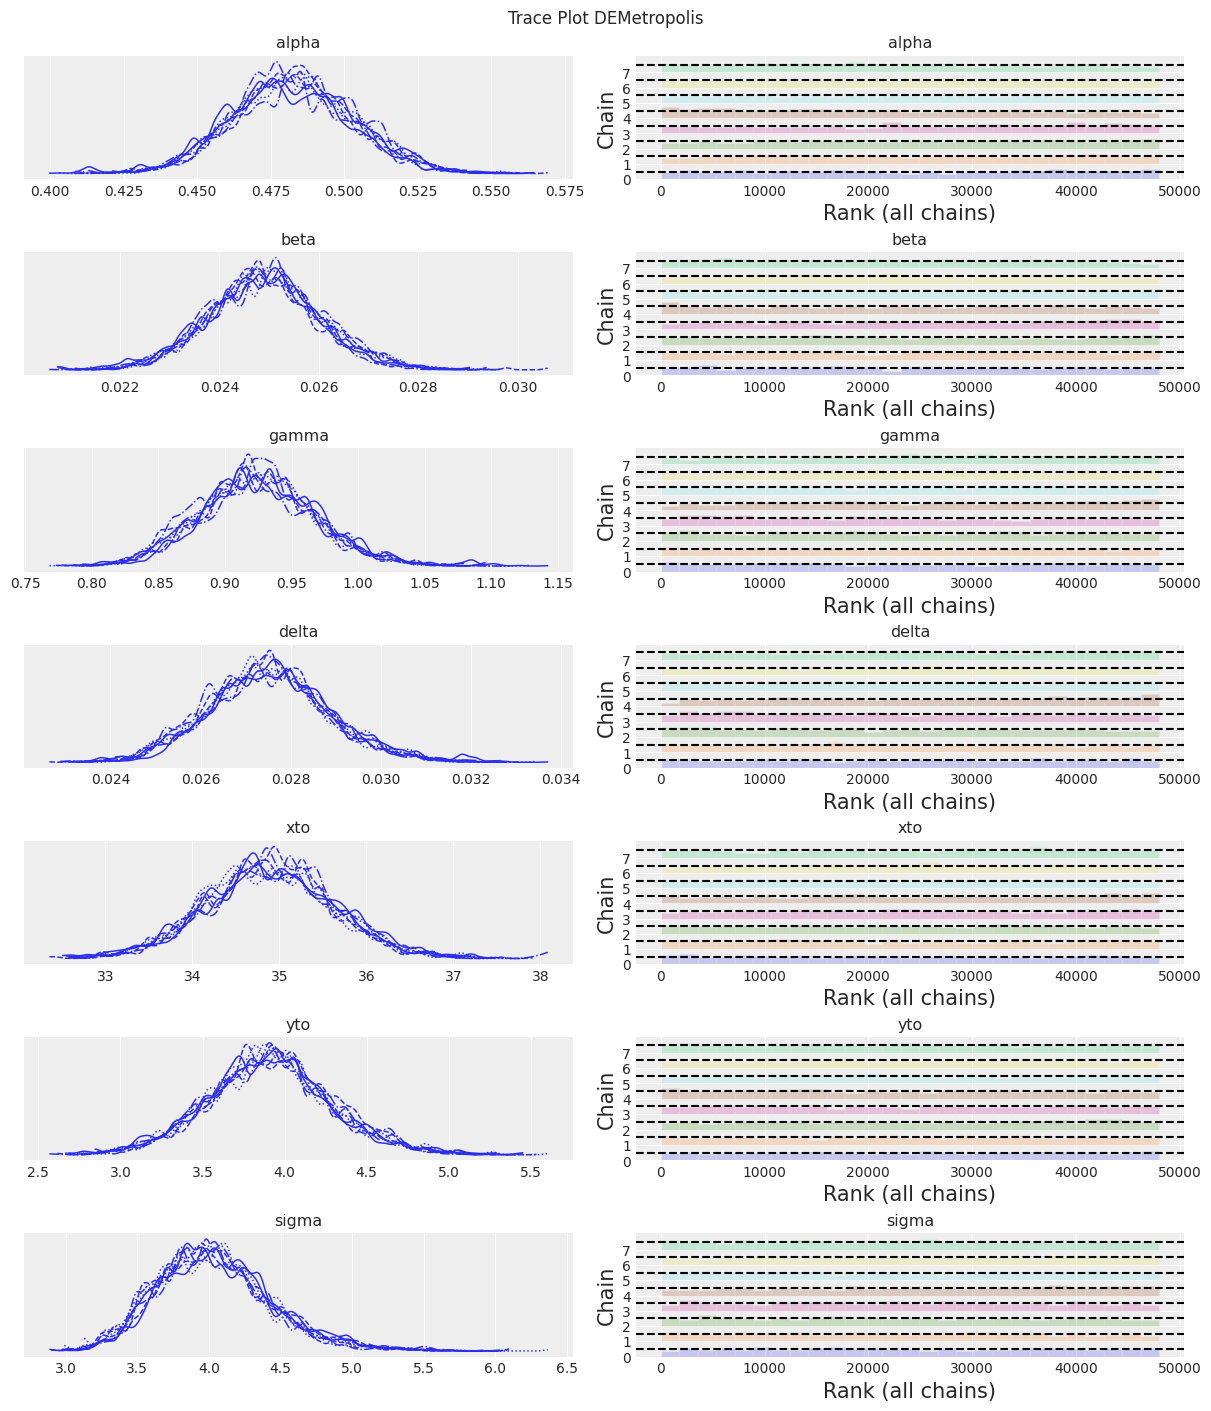

In [26]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

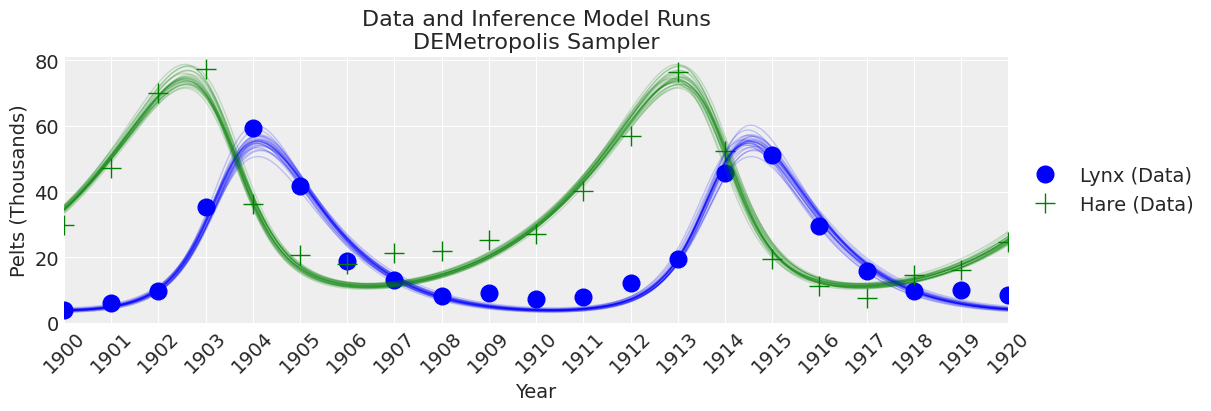

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [28]:
sampler = "Metropolis"
tune = draws = 5000
with model:
    trace_M = pm.sample(step=[pm.Metropolis(vars_list)], tune=tune, draws=draws)
trace = trace_M
az.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [gamma]
>Metropolis: [delta]
>Metropolis: [xto]
>Metropolis: [yto]
>Metropolis: [sigma]


/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1915031652163D+04   r2 =  0.9611118649876D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1915031652163D+04   r2 =  0.9611118649876D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1915031652163D+04   r2 =  0.7957838904575D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1915031652163D+04   r2 =  0.7957838904575D-13
 lsoda--  warning..internal t (=r1) 

/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 76 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.480  0.023   0.439    0.524      0.003    0.002      55.0     160.0   
beta    0.025  0.001   0.023    0.027      0.000    0.000     136.0     533.0   
gamma   0.931  0.049   0.844    1.031      0.007    0.005      54.0     138.0   
delta   0.028  0.002   0.025    0.031      0.000    0.000      56.0     119.0   
xto    34.901  0.825  33.291   36.410      0.029    0.020     820.0    1570.0   
yto     3.857  0.479   2.983    4.793      0.048    0.034     100.0     183.0   
sigma   4.131  0.508   3.235    5.071      0.010    0.007    2712.0    3848.0   

       r_hat  
alpha   1.05  
beta    1.02  
gamma   1.05  
delta   1.05  
xto     1.01  
yto     1.03  
sigma   1.00

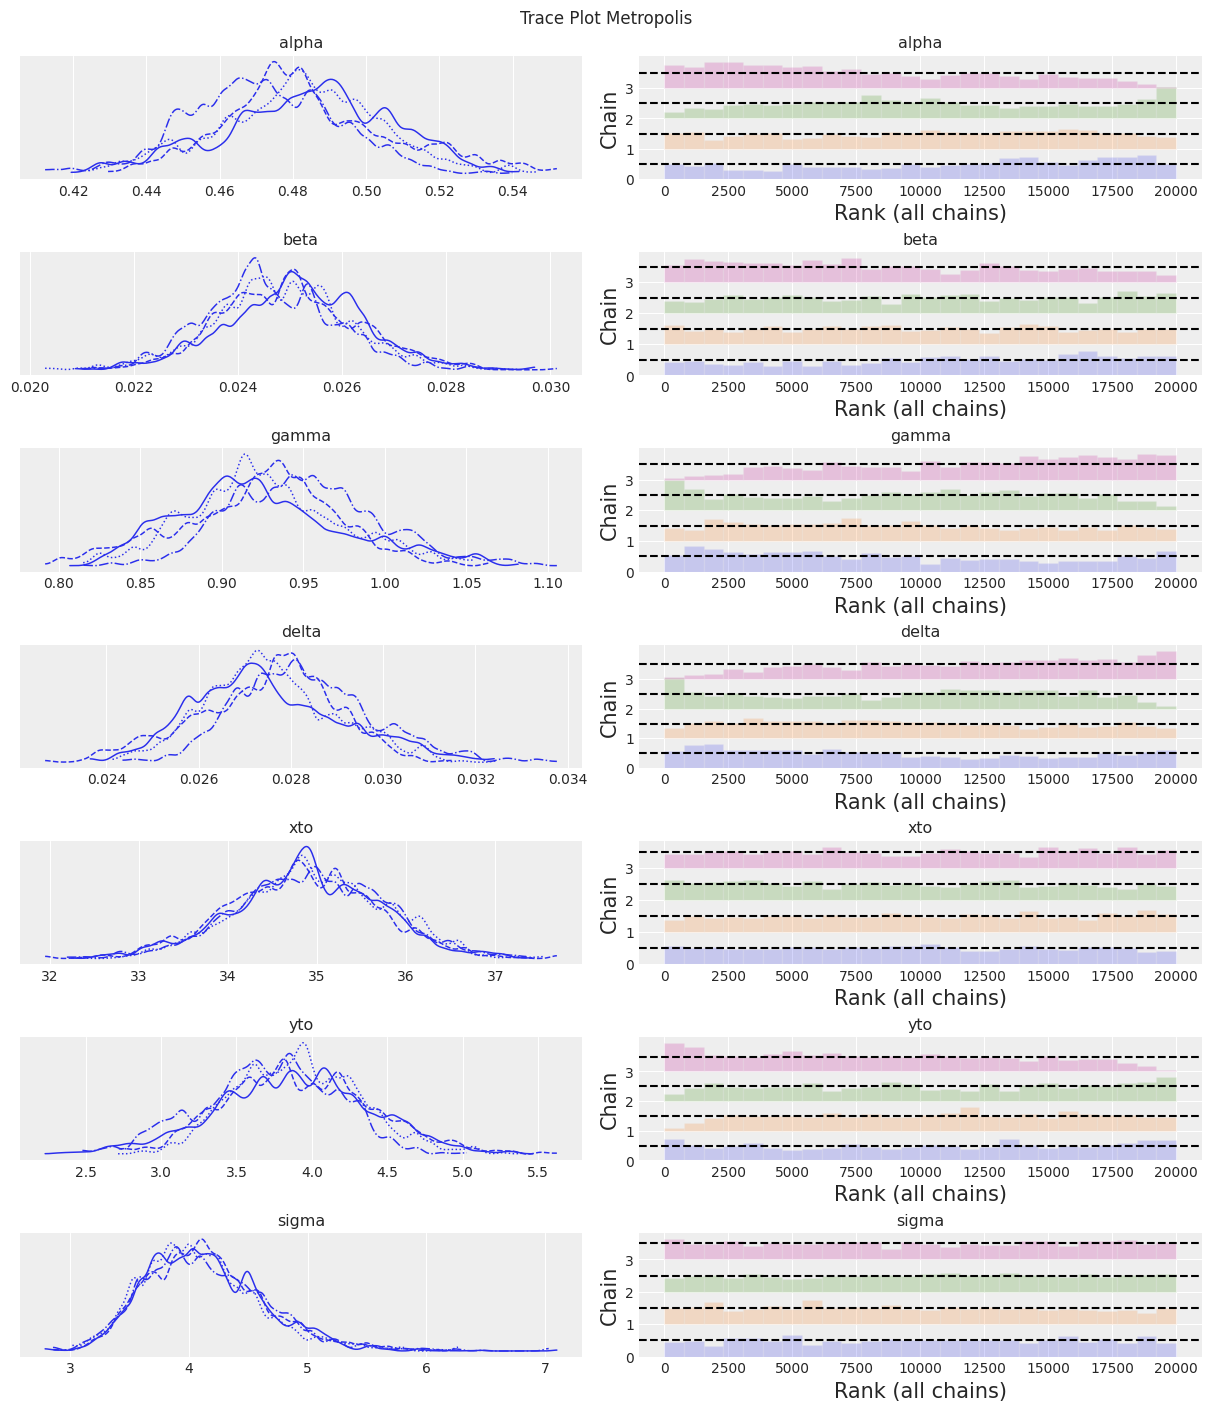

In [29]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

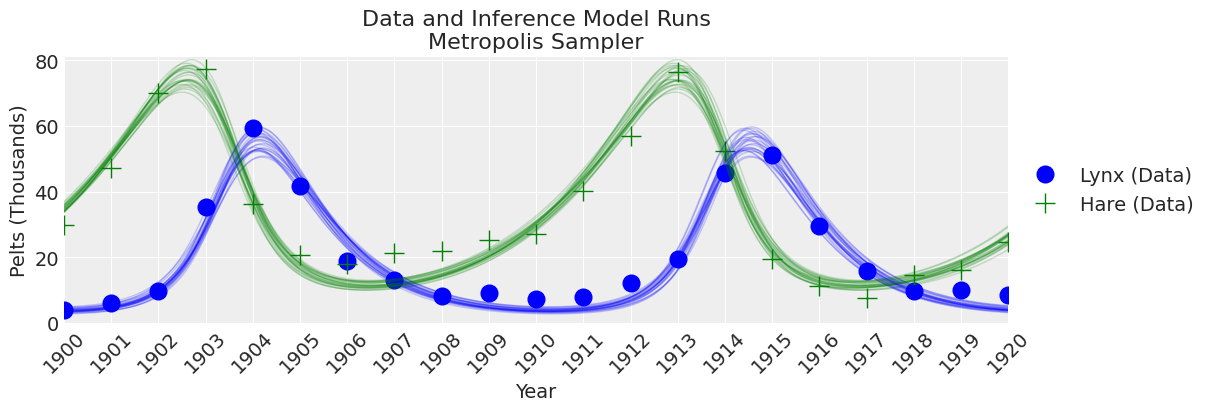

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [31]:
sampler = "SMC with Likelihood"
draws = 2000
with model:
    trace_SMC_like = pm.sample_smc(draws)
trace = trace_SMC_like
az.summary(trace)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.482  0.025   0.434    0.527      0.000    0.000   15891.0   15985.0   
beta    0.025  0.001   0.022    0.028      0.000    0.000   16108.0   15940.0   
gamma   0.926  0.053   0.825    1.024      0.000    0.000   16009.0   15813.0   
delta   0.028  0.002   0.025    0.031      0.000    0.000   16064.0   15500.0   
xto    34.897  0.837  33.310   36.486      0.007    0.005   15463.0   15738.0   
yto     3.892  0.480   3.003    4.809      0.004    0.003   15921.0   15545.0   
sigma   4.120  0.491   3.268    5.079      0.004    0.003   14904.0   15802.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
xto      1.0  
yto      1.0  
sigma    1.0

In [32]:
trace.sample_stats._t_sampling

49.498642683029175

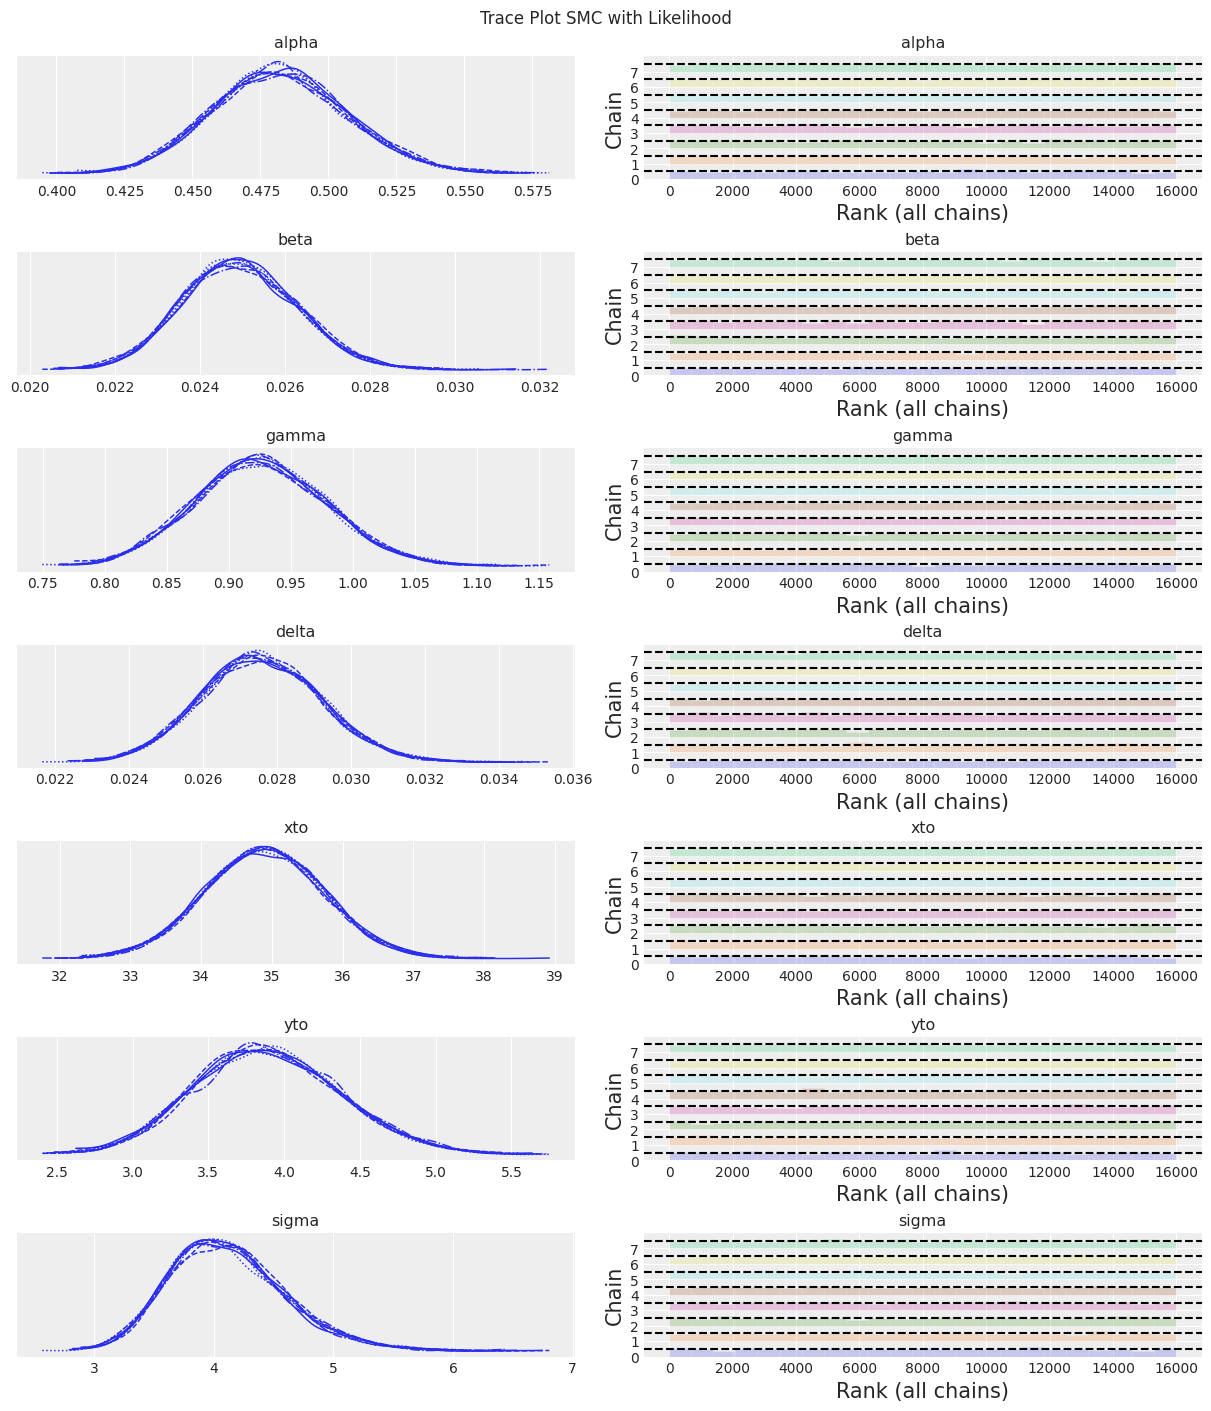

In [33]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

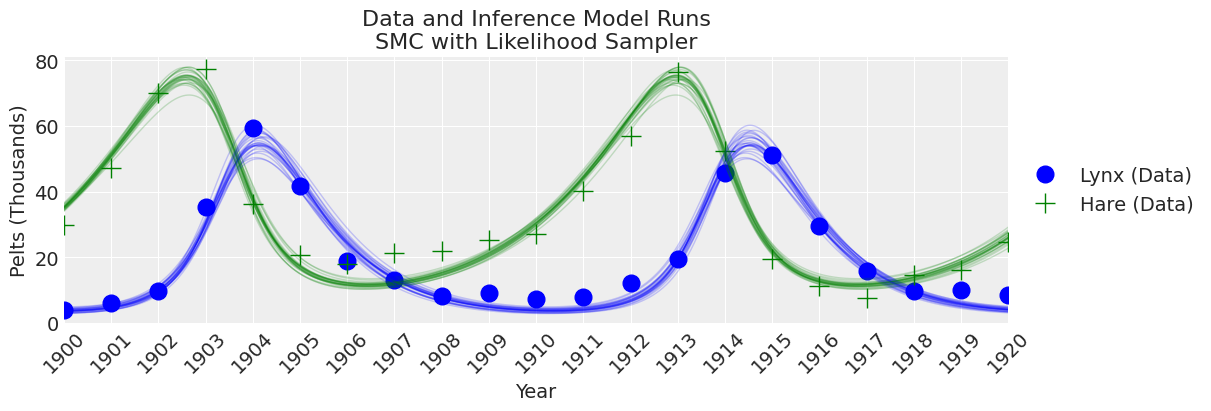

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [35]:
# simulator function based on the signature rng, parameters, size.
def simulator_forward_model(rng, alpha, beta, gamma, delta, xt0, yt0, sigma, size=None):
    theta = alpha, beta, gamma, delta, xt0, yt0
    mu = odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))
    return rng.normal(mu, sigma)

In [36]:
with pm.Model() as model:
    # Specify prior distributions for model parameters
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    pm.Simulator(
        "Y_obs",
        simulator_forward_model,
        params=(alpha, beta, gamma, delta, xt0, yt0, sigma),
        epsilon=1,
        observed=data[["hare", "lynx"]].values,
    )

In [37]:
sampler = "SMC_epsilon=1"
draws = 2000
with model:
    trace_SMC_e1 = pm.sample_smc(draws=draws, progressbar=False)
trace = trace_SMC_e1
az.summary(trace)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.478  0.017   0.457    0.516      0.006    0.004       8.0       8.0   
beta    0.025  0.001   0.023    0.027      0.000    0.000       8.0       8.0   
gamma   0.933  0.030   0.867    0.962      0.010    0.008       8.0       8.0   
delta   0.028  0.001   0.025    0.029      0.000    0.000       8.0       8.0   
xto    34.843  0.973  32.820   36.158      0.343    0.252       8.0       8.0   
yto     3.739  0.336   3.345    4.343      0.117    0.086       8.0       8.0   
sigma   2.117  0.633   1.260    3.249      0.221    0.163       8.0      10.0   

       r_hat  
alpha  10.00  
beta    9.09  
gamma   4.56  
delta   8.25  
xto     9.68  
yto     5.13  
sigma   5.11

/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data app

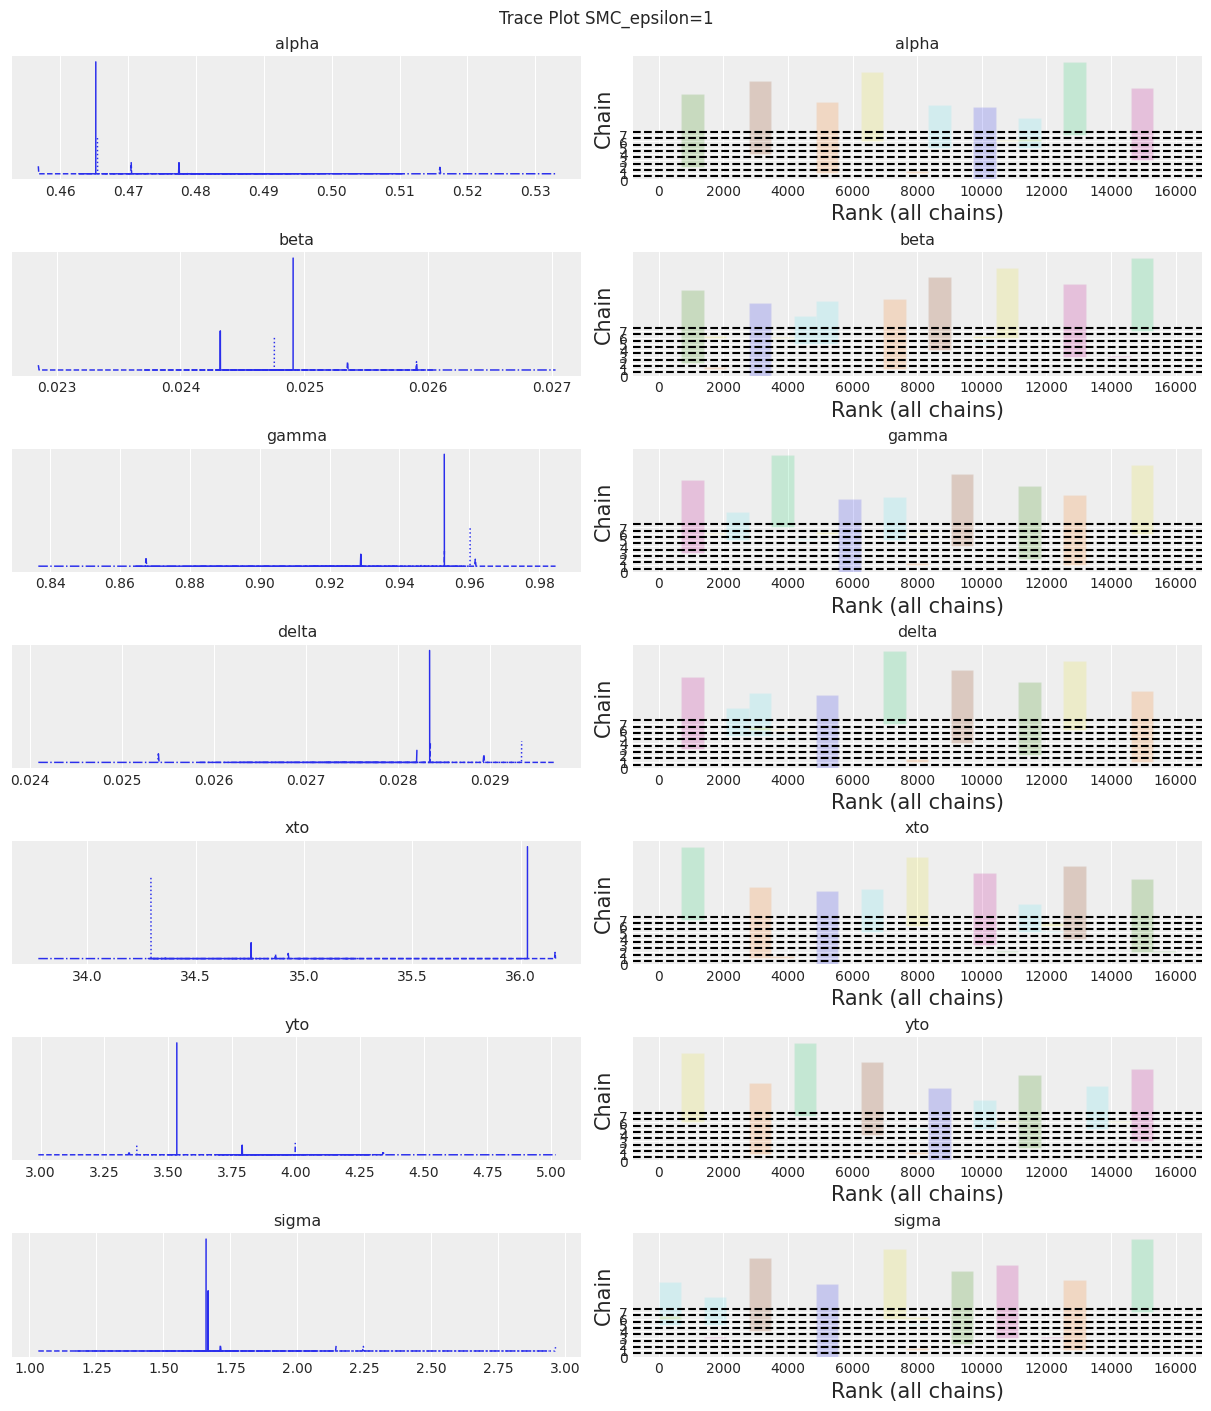

In [38]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

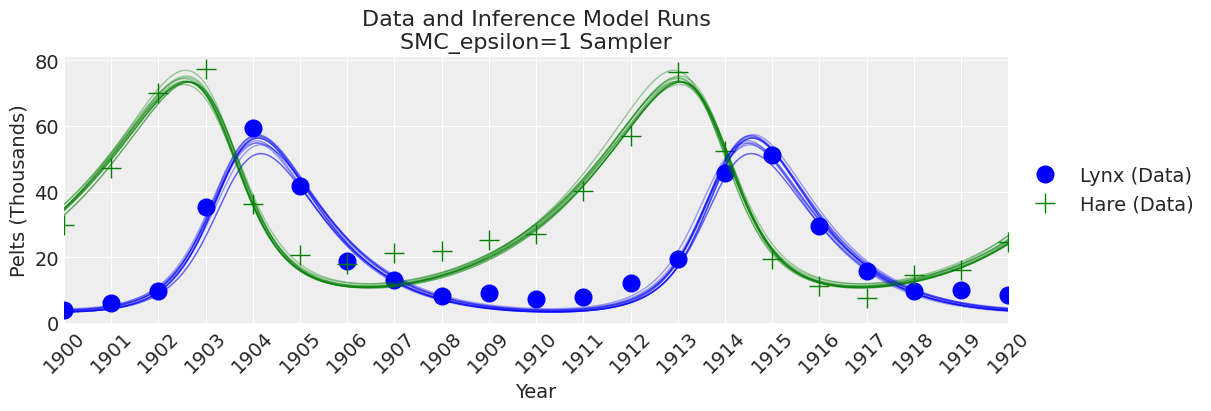

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [40]:
with pm.Model() as model:
    # Specify prior distributions for model parameters
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    pm.Simulator(
        "Y_obs",
        simulator_forward_model,
        params=(alpha, beta, gamma, delta, xt0, yt0, sigma),
        epsilon=10,
        observed=data[["hare", "lynx"]].values,
    )

In [41]:
sampler = "SMC epsilon=10"
draws = 2000
with model:
    trace_SMC_e10 = pm.sample_smc(draws=draws)
trace = trace_SMC_e10
az.summary(trace)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (8) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.482  0.035   0.417    0.548      0.000    0.000   15195.0   14434.0   
beta    0.025  0.003   0.021    0.031      0.000    0.000   15909.0   16174.0   
gamma   0.928  0.072   0.792    1.061      0.001    0.000   15509.0   15658.0   
delta   0.028  0.002   0.023    0.032      0.000    0.000   15589.0   15046.0   
xto    34.885  0.969  33.073   36.729      0.008    0.005   15749.0   15342.0   
yto     3.898  0.725   2.524    5.224      0.006    0.004   15510.0   15279.0   
sigma   1.439  1.075   0.022    3.355      0.009    0.006   14313.0   14342.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
xto      1.0  
yto      1.0  
sigma    1.0

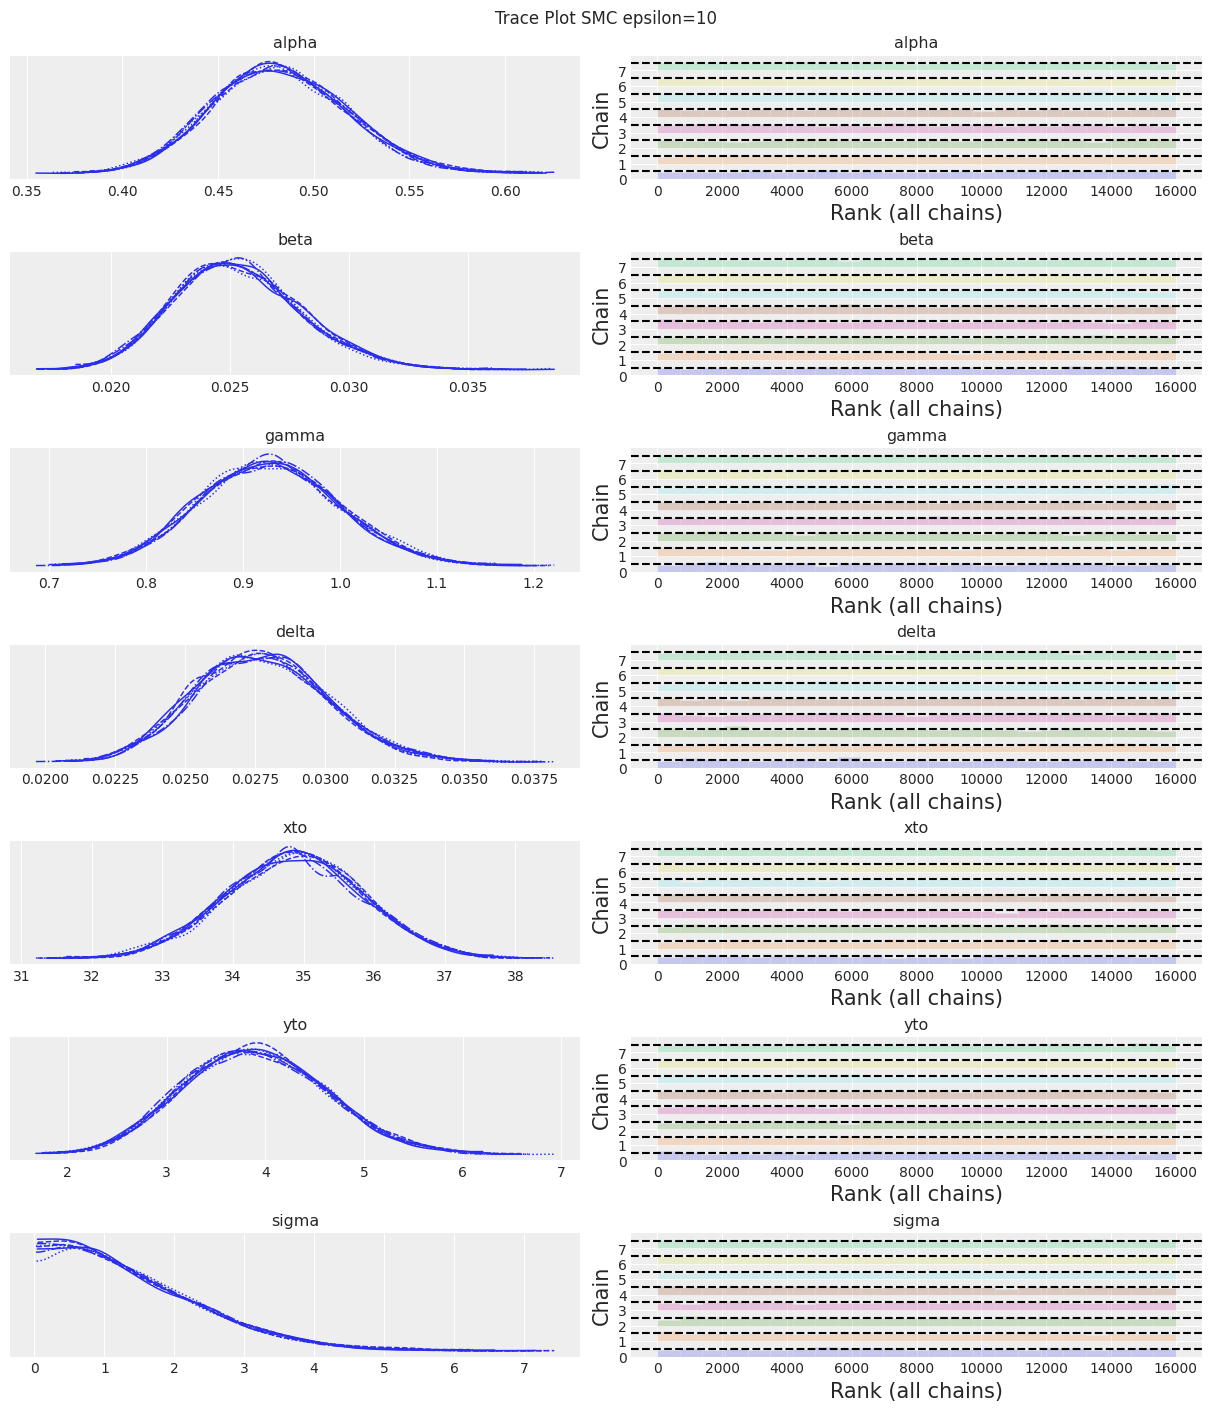

In [42]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

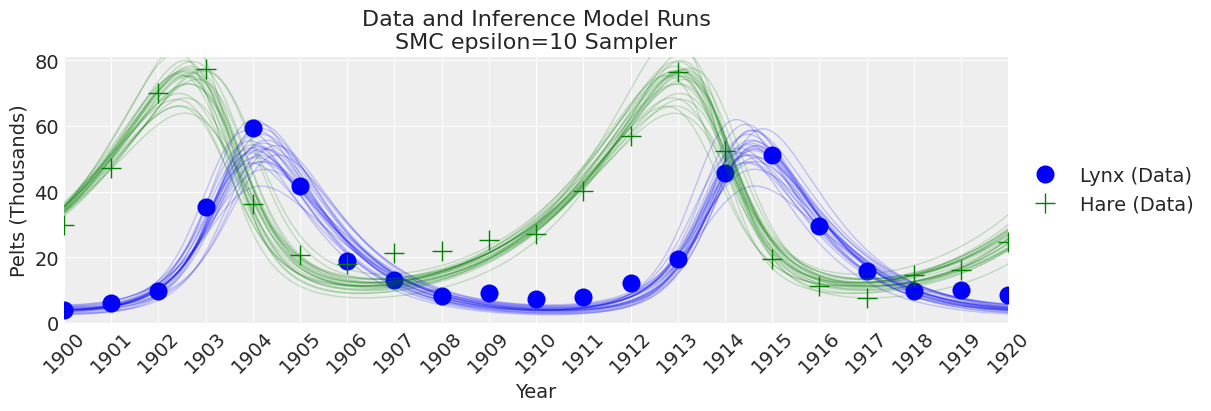

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


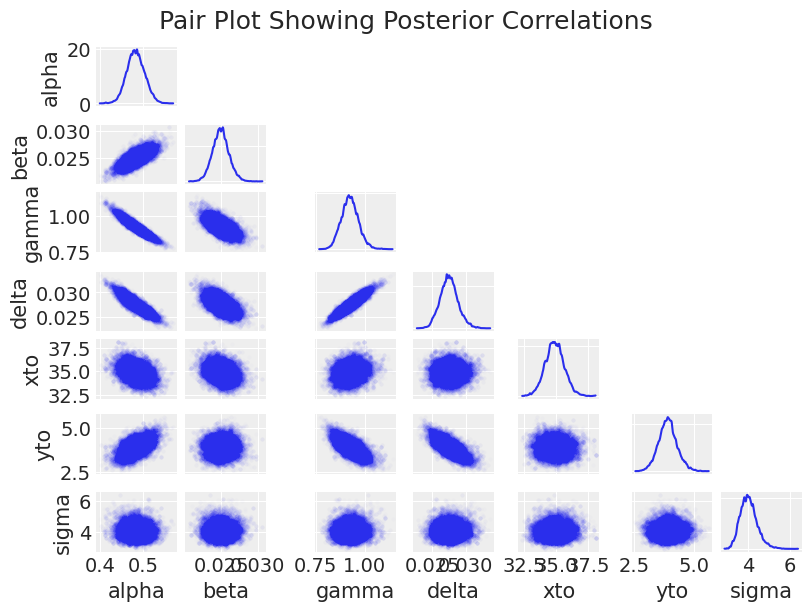

In [44]:
az.plot_pair(trace_DEM, figsize=(8, 6), scatter_kwargs=dict(alpha=0.01), marginals=True)
plt.suptitle("Pair Plot Showing Posterior Correlations", size=18);

In [45]:
def rhs_pymcode(y, t, p):
    dX_dt = p[0] * y[0] - p[1] * y[0] * y[1]
    dY_dt = -p[2] * y[1] + p[3] * y[0] * y[1]
    return [dX_dt, dY_dt]

In [46]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=data.year.values, n_states=2, n_theta=4, t0=data.year.values[0]
)

In [47]:
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    ode_solution = ode_model(y0=[xt0, yt0], theta=[alpha, beta, gamma, delta])

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

In [48]:
sampler = "NUTS PyMC ODE"
tune = draws = 15
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws)

Only 15 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, xto, yto, sigma]


/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1901000000000D+04
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.1900000000000D+04   r2 =  0.1900000000000D+04
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1902000000000D+04
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.1900000000000D+04   r2 =  0.1900000000000D+04
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.1902000000000D+04


/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.4617204404237D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.4617204404237D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.1521898600141D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.1521898600141D-16
 lsoda--  warning..internal t (=r1) 

/home/jbris/.cache/pypoetry/virtualenvs/pymc-ode-6-us88lL-py3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.1167286137275D-24
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.9726187309640D-25
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.1945237461928D-24
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.1945237461928D-24
 lsoda--  warning..internal t (=r1) 

Sampling 4 chains for 15 tune and 15 draw iterations (60 + 60 draws total) took 84 seconds.
The number of samples is too small to check convergence reliably.


In [49]:
trace = trace_pymc_ode
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.502  0.037   0.455    0.566      0.012    0.009      11.0      33.0   
beta    0.026  0.002   0.023    0.030      0.000    0.000      20.0      20.0   
gamma   0.890  0.072   0.767    0.982      0.022    0.016      12.0      77.0   
delta   0.026  0.002   0.023    0.030      0.001    0.000      12.0      22.0   
xto    34.742  0.826  33.520   36.650      0.145    0.103      32.0      43.0   
yto     4.218  0.606   3.374    5.571      0.180    0.133      13.0      22.0   
sigma   4.499  0.704   3.399    5.997      0.200    0.145      10.0      29.0   

       r_hat  
alpha   1.63  
beta    1.39  
gamma   1.55  
delta   1.66  
xto     1.10  
yto     1.57  
sigma   1.73

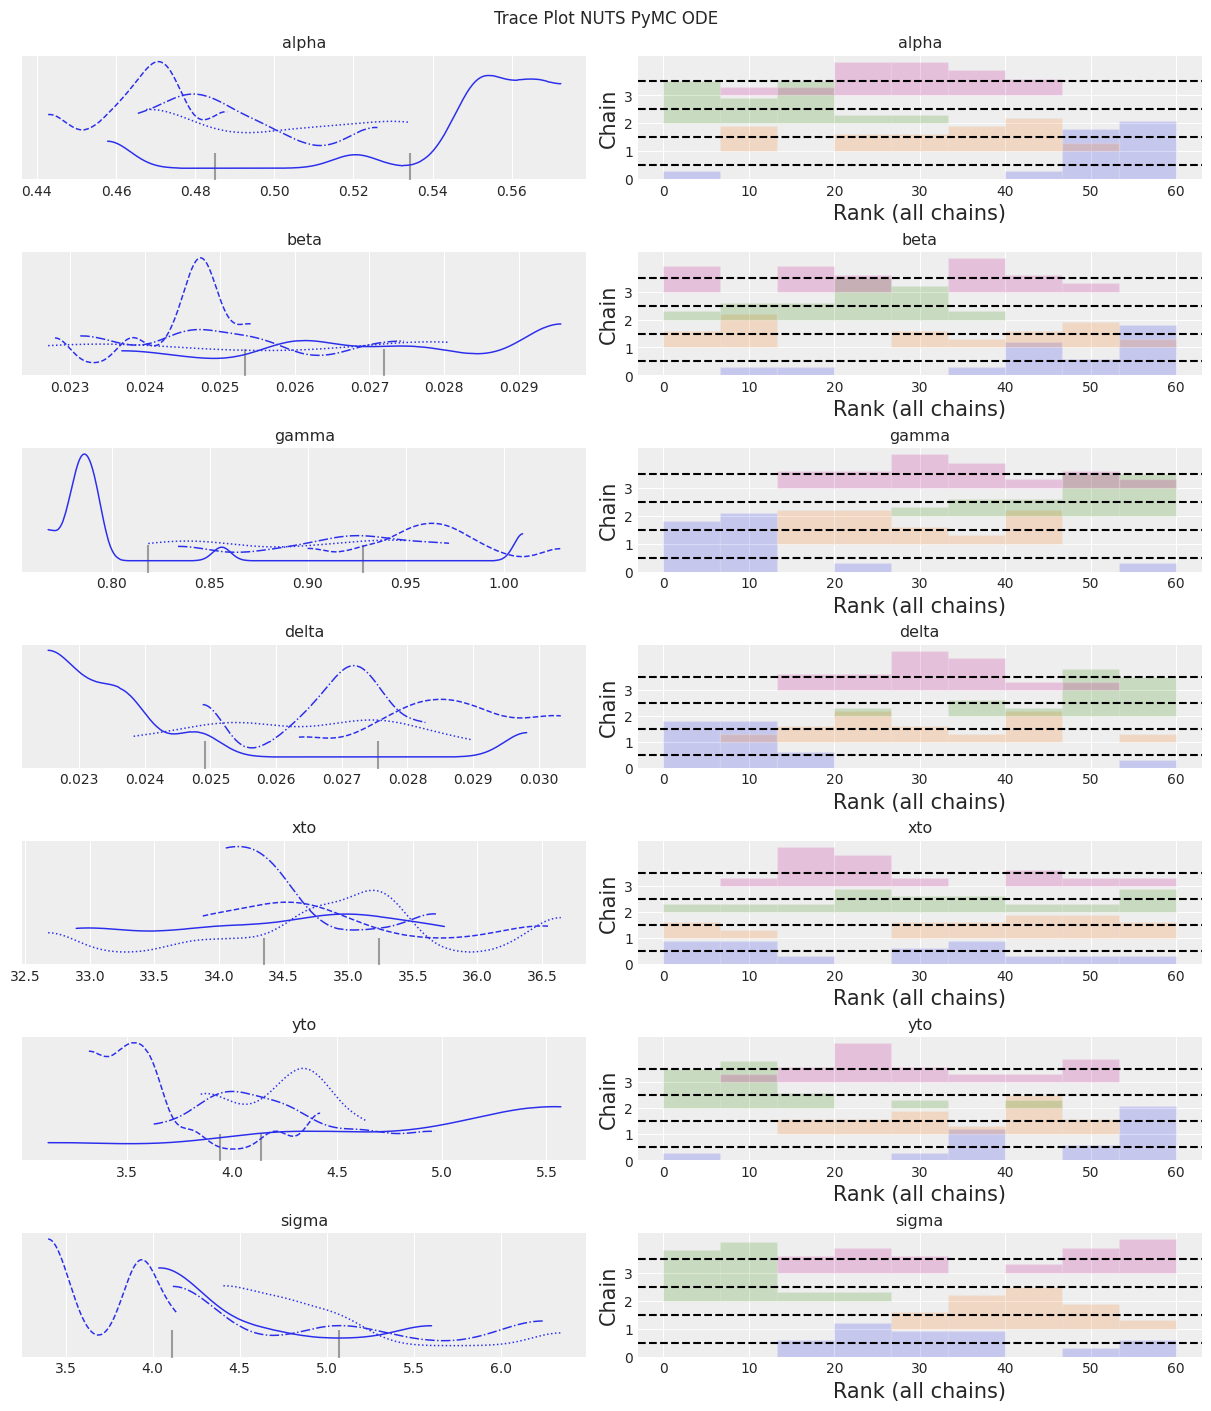

In [50]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

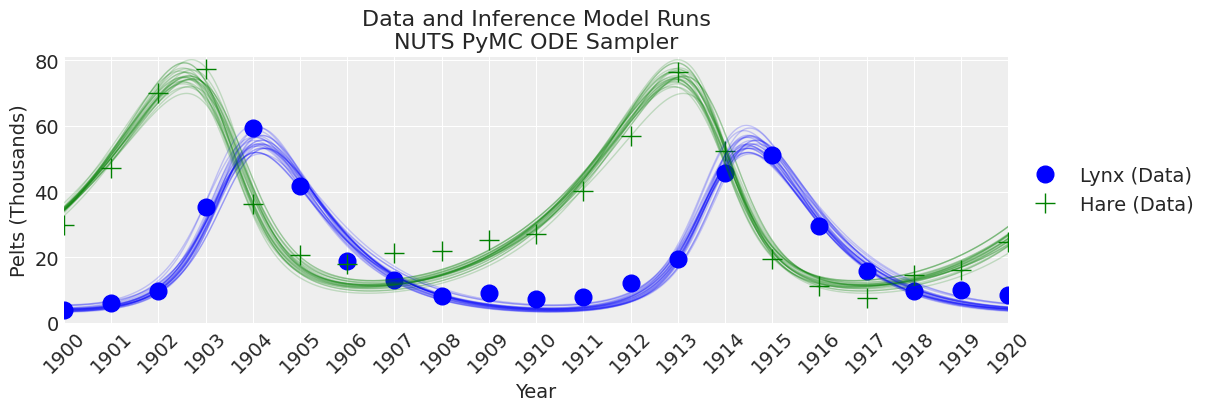

In [51]:
_, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [52]:
# Lotka-Volterra forward simulation model using scan
def lv_scan_simulation_model(theta, steps_year=100, years=21):
    # variables to control time steps
    n_steps = years * steps_year
    dt = 1 / steps_year

    # PyMC model
    with pm.Model() as model:
        # Priors (these are static for testing)
        alpha = theta[0]
        beta = theta[1]
        gamma = theta[2]
        delta = theta[3]
        xt0 = theta[4]
        yt0 = theta[5]

        # Lotka-Volterra calculation function
        ## Similar to the right-hand-side functions used earlier
        ## but with dt applied to the equations
        def ode_update_function(x, y, alpha, beta, gamma, delta):
            x_new = x + (alpha * x - beta * x * y) * dt
            y_new = y + (-gamma * y + delta * x * y) * dt
            return x_new, y_new

        # Pytensor scan looping function
        ## The function argument names are not intuitive in this context!
        result, updates = pytensor.scan(
            fn=ode_update_function,  # function
            outputs_info=[xt0, yt0],  # initial conditions
            non_sequences=[alpha, beta, gamma, delta],  # parameters
            n_steps=n_steps,  # number of loops
        )

        # Put the results together and track the result
        pm.Deterministic("result", pm.math.stack([result[0], result[1]], axis=1))

    return model

Sampling: []
Sampling: []
Sampling: []
Sampling: []


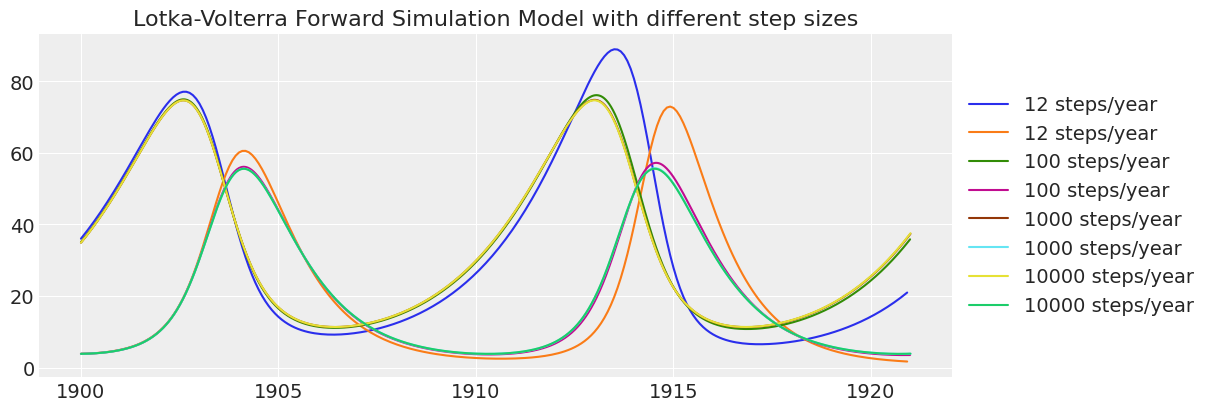

In [53]:
_, ax = plt.subplots(figsize=(12, 4))

steps_years = [12, 100, 1000, 10000]
for steps_year in steps_years:
    time = np.arange(1900, 1921, 1 / steps_year)
    model = lv_scan_simulation_model(theta, steps_year=steps_year)
    with model:
        prior = pm.sample_prior_predictive(1)
    ax.plot(time, prior.prior.result[0][0].values, label=str(steps_year) + " steps/year")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Lotka-Volterra Forward Simulation Model with different step sizes");

In [54]:
def lv_scan_inference_model(theta, steps_year=100, years=21):
    # variables to control time steps
    n_steps = years * steps_year
    dt = 1 / steps_year

    # variables to control indexing to get annual values
    segment = [True] + [False] * (steps_year - 1)
    boolist_idxs = []
    for _ in range(years):
        boolist_idxs += segment

    # PyMC model
    with pm.Model() as model:
        # Priors
        alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
        beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
        gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
        delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
        xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
        yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
        sigma = pm.HalfNormal("sigma", 10)

        # Lotka-Volterra calculation function
        def ode_update_function(x, y, alpha, beta, gamma, delta):
            x_new = x + (alpha * x - beta * x * y) * dt
            y_new = y + (-gamma * y + delta * x * y) * dt
            return x_new, y_new

        # Pytensor scan is a looping function
        result, updates = pytensor.scan(
            fn=ode_update_function,  # function
            outputs_info=[xt0, yt0],  # initial conditions
            non_sequences=[alpha, beta, gamma, delta],  # parameters
            n_steps=n_steps,
        )  # number of loops

        # Put the results together
        final_result = pm.math.stack([result[0], result[1]], axis=1)
        # Filter the results down to annual values
        annual_value = final_result[np.array(boolist_idxs), :]

        # Likelihood function
        pm.Normal("Y_obs", mu=annual_value, sigma=sigma, observed=data[["hare", "lynx"]].values)
    return model

In [55]:
steps_year = 100
model = lv_scan_inference_model(theta, steps_year=steps_year)
sampler = "NUTS Pytensor Scan"
tune = draws = 50
with model:
    trace_scan = pm.sample(tune=tune, draws=draws)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, xto, yto, sigma]


Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 72 seconds.
The number of samples is too small to check convergence reliably.


In [56]:
trace = trace_scan
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.479  0.022   0.440    0.516      0.002    0.001     105.0     159.0   
beta    0.025  0.001   0.023    0.028      0.000    0.000     139.0     102.0   
gamma   0.932  0.045   0.852    1.014      0.005    0.003      97.0     119.0   
delta   0.028  0.001   0.025    0.030      0.000    0.000      86.0     132.0   
xto    34.940  0.878  32.928   36.336      0.051    0.036     294.0     145.0   
yto     4.018  0.429   3.313    4.795      0.051    0.037      77.0      64.0   
sigma   4.130  0.444   3.423    5.041      0.057    0.041      68.0      59.0   

       r_hat  
alpha   1.02  
beta    1.04  
gamma   1.02  
delta   1.03  
xto     1.04  
yto     1.05  
sigma   1.05

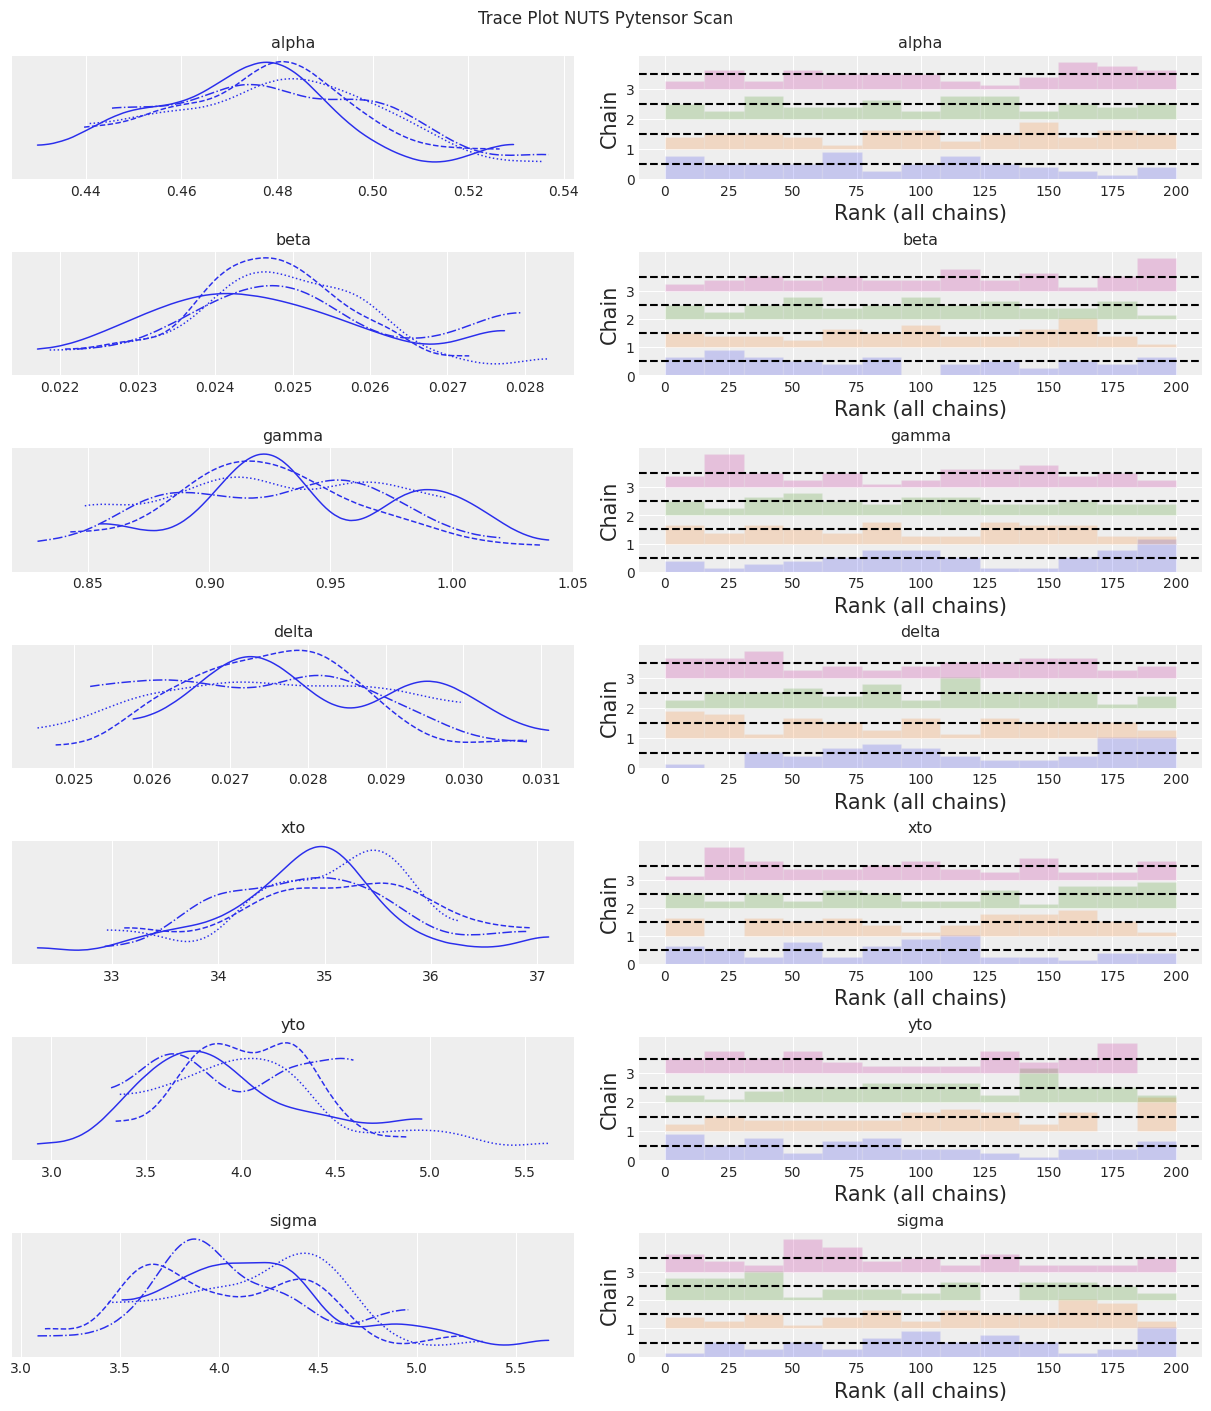

In [57]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

In [58]:
time = np.arange(1900, 1921, 0.01)
odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,)).shape

(2100, 2)

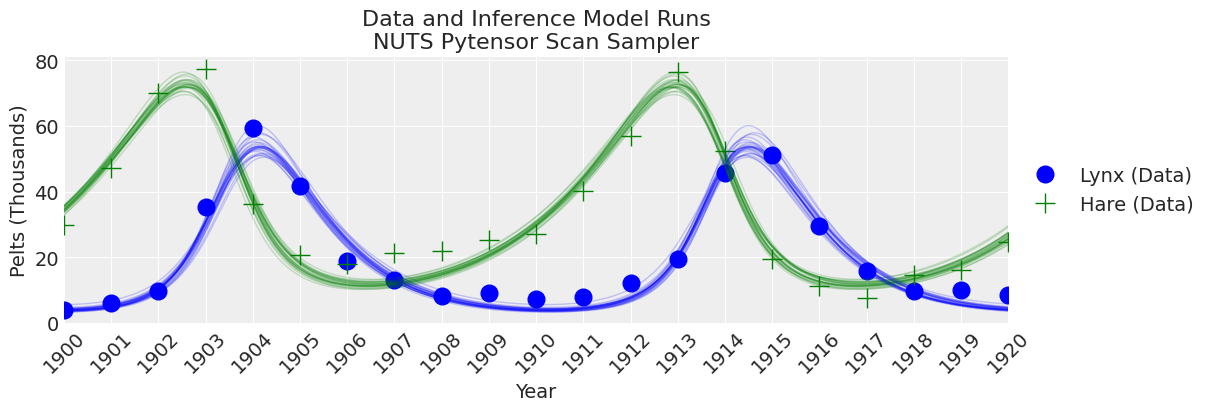

In [59]:
_, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

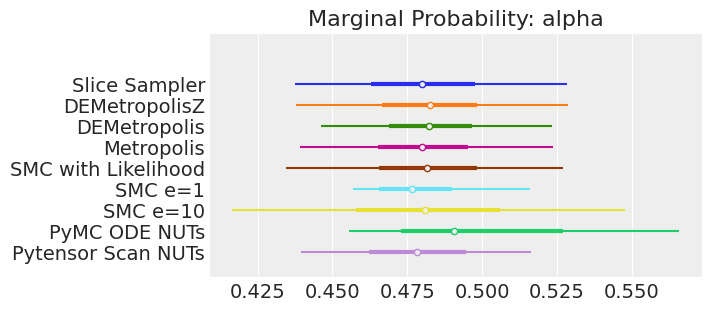

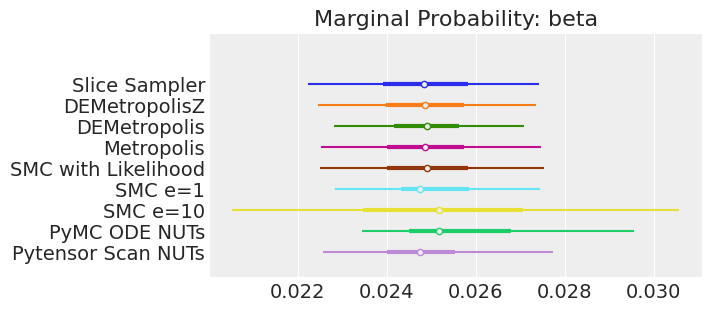

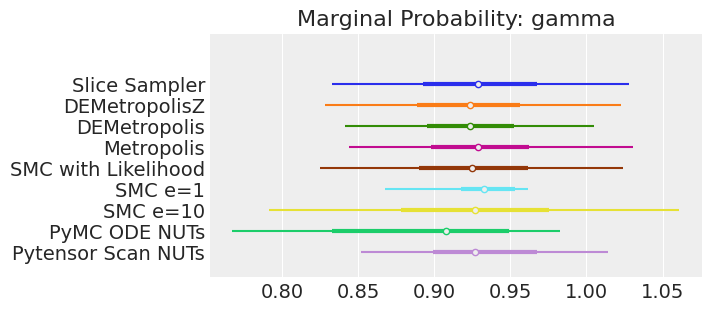

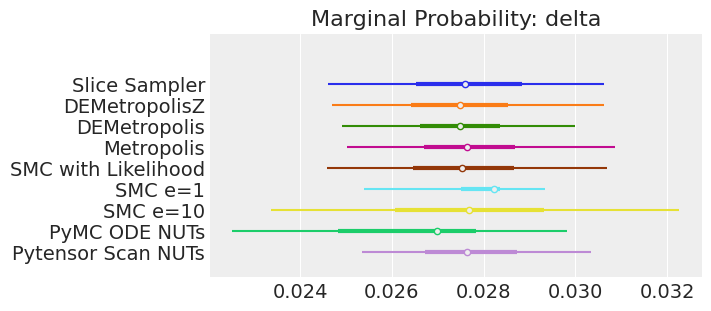

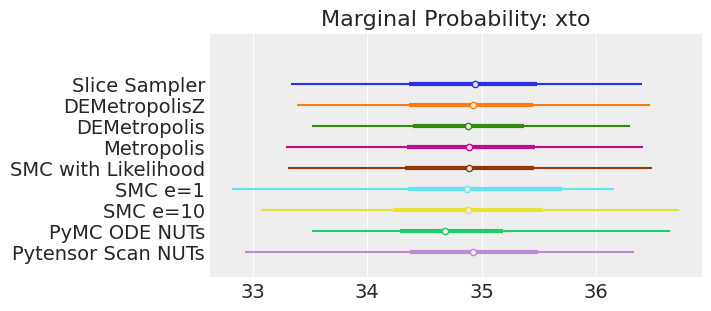

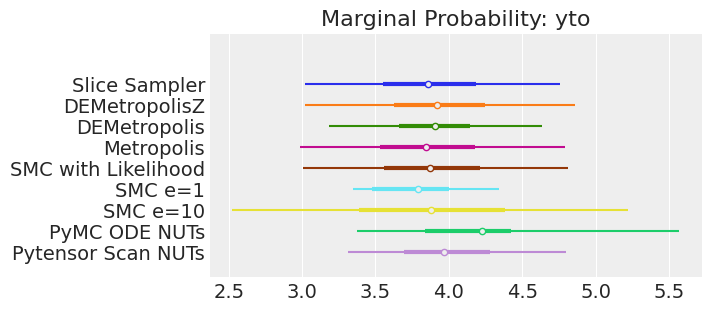

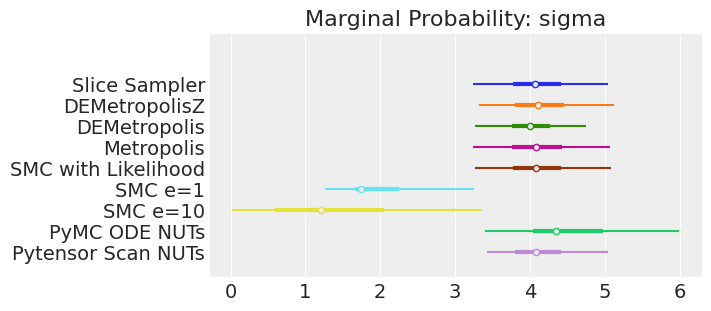

In [60]:
# Make lists with variable for looping
var_names = [str(s).split("_")[0] for s in list(model.values_to_rvs.keys())[:-1]]
# Make lists with model results and model names for plotting
inference_results = [
    trace_slice,
    trace_DEMZ,
    trace_DEM,
    trace_M,
    trace_SMC_like,
    trace_SMC_e1,
    trace_SMC_e10,
    trace_pymc_ode,
    trace_scan,
]
model_names = [
    "Slice Sampler",
    "DEMetropolisZ",
    "DEMetropolis",
    "Metropolis",
    "SMC with Likelihood",
    "SMC e=1",
    "SMC e=10",
    "PyMC ODE NUTs",
    "Pytensor Scan NUTs",
]

# Loop through variable names
for var_name in var_names:
    axes = az.plot_forest(
        inference_results,
        model_names=model_names,
        var_names=var_name,
        kind="forestplot",
        legend=False,
        combined=True,
        figsize=(7, 3),
    )
    axes[0].set_title(f"Marginal Probability: {var_name}")
    # Clean up ytick labels
    ylabels = axes[0].get_yticklabels()
    new_ylabels = []
    for label in ylabels:
        txt = label.get_text()
        txt = txt.replace(": " + var_name, "")
        label.set_text(txt)
        new_ylabels.append(label)
    axes[0].set_yticklabels(new_ylabels)

    plt.show();